In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [ ]:
#creating dataframes for both super and non-super foods
superfoods_df = pd.read_csv("superfoods_tagged.csv")
foods_df = pd.read_csv("Foods_tagged.csv")


#dropping all columns that don't exist in both dataframes
columns_to_drop = superfoods_df.columns.difference(foods_df.columns)
superfoods_df = superfoods_df.drop(columns=columns_to_drop)

columns_to_drop = foods_df.columns.difference(superfoods_df.columns)
foods_df = foods_df.drop(columns=columns_to_drop)

# creating a 'superfood' feature
# CHANGED: Use 1/0 instead of True/False to avoid dtype issues
superfoods_df["superfood"] = 1
foods_df["superfood"] = 0

#combining the dataframes into one
df = pd.concat([superfoods_df, foods_df], ignore_index=True)

## Model 1: Perceptron

In [ ]:
# Define the feature columns
feature_columns = ['Total lipid (fat) (G)', 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)', 'Cholesterol (MG)',
                   'Carbohydrate, by difference (G)', 'Fiber, total dietary (G)', 'Total Sugars (G)', 'Protein (G)', 'Vitamin D (D2 + D3) (UG)',
                   'Calcium, Ca (MG)', 'Iron, Fe (MG)', 'Potassium, K (MG)', 'Sodium, Na (MG)']

# Drop rows with any NaN values in the feature columns or the 'superfood' column
# This ensures that both X and y will be clean
df_cleaned = df.dropna(subset=feature_columns + ['superfood'])

print(df_cleaned.shape)
# standardize feature columns
for feat in df_cleaned.columns:
    if feat in feature_columns:
        df_cleaned[f'{feat}'] = (df_cleaned[feat] - df_cleaned[feat].mean()) / df_cleaned[feat].std()

# using required macronutrients as x features from the cleaned dataframe
x = [df_cleaned[col] for col in feature_columns]

(2081, 158)


/tmp/ipython-input-20967488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[f'{feat}'] = (df_cleaned[feat] - df_cleaned[feat].mean()) / df_cleaned[feat].std()


In [ ]:
X = np.vstack([np.ones(len(x[0])), x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12]]).T
y = [1 if super_food else -1 for super_food in df_cleaned['superfood']]
w = np.array([1, -1, 0, -2, 1, 2, 1, 2, 1, -1, 0, -1, 1, 0])

In [ ]:
def linear_perceptron(X, y, w, alpha = 1, max_iter = None):
    """
    calculate and return the final weight vector of a perceptron algorithm

    Args:
    - X (np array): a 2d-array (including bias column of 1s) with columns equal to  𝑥  features
    - y (np array): a 1d-array of labels (-1 or 1)
    - w (np array): an initial w vector of same dimension as the columns of X
    - alpha (int): the learning rate, with default value of 1
    - max_iter (int): the maximum number of iterations for the algorithm to run, with default value of None

    Returns:
    - w (np array): final weight vector
    """
    runalg = True
    i = 0
    iter = 0

    # ADDED - Initialize tracking lists
    accuracies = []
    misclassifications = []

    while runalg:

        pred = 0
        # for the current i, make the prediction
        obs = np.dot(X[i,:], w)
        if obs >= 0:
          pred = 1
        else:
          pred = -1
        # check if it is correct
        if pred != y[i]:
          # if not, update w
          w = w - alpha*(-y[i]*X[i,:])
        # add one to i
        i += 1
        # if you've just updated the last i (the last observation in the data), add one to iter
        if i == len(y):

          # ADDED - Calculate metrics at end of each epoch
          predictions = np.where(X @ w >= 0, 1, -1)
          accuracy = np.mean(predictions == y)
          misclass = np.sum(predictions != y)
          accuracies.append(accuracy)
          misclassifications.append(misclass)

          iter += 1
          i = 0
        # if you've set a max_iter, and if you've REACHED the max_iter, set runalg = False, print w and iter, and break
        if iter == max_iter:
          runalg = False
          print(iter)
          print(w)

    # CHANGED THIS LINE - Return all three values
    return w, accuracies, misclassifications

In [ ]:
fin_w, accuracies, misclass = linear_perceptron(X, y, w, 0.0001, 1000)
print(fin_w)

1000
[-1.11730000e+00  9.92166996e-03 -3.82777377e-03 -1.25382784e+00
  4.98108555e-02  3.87253622e-03  1.86033140e-03 -2.66089900e-03
 -1.49818256e-02 -8.80910330e-01  3.36773493e-03  1.22254791e-02
 -2.20106938e-03  6.60137298e-04]
[-1.11730000e+00  9.92166996e-03 -3.82777377e-03 -1.25382784e+00
  4.98108555e-02  3.87253622e-03  1.86033140e-03 -2.66089900e-03
 -1.49818256e-02 -8.80910330e-01  3.36773493e-03  1.22254791e-02
 -2.20106938e-03  6.60137298e-04]


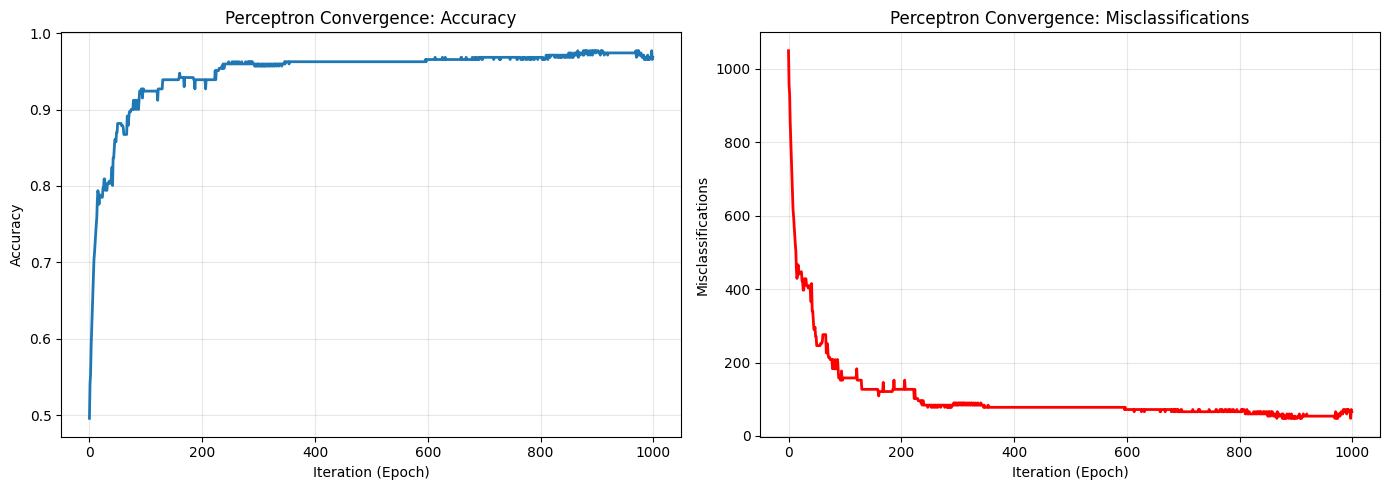

In [ ]:
# CONVERGENCE PLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(range(len(accuracies)), accuracies, linewidth=2)
ax1.set_xlabel('Iteration (Epoch)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Perceptron Convergence: Accuracy')
ax1.grid(True, alpha=0.3)

# Misclassifications plot
ax2.plot(range(len(misclass)), misclass, color='red', linewidth=2)
ax2.set_xlabel('Iteration (Epoch)')
ax2.set_ylabel('Misclassifications')
ax2.set_title('Perceptron Convergence: Misclassifications')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 3D FEATURE PROJECTION

fig = px.scatter_3d(df_cleaned,
                    x='Total lipid (fat) (G)',
                    y='Fiber, total dietary (G)',
                    z='Protein (G)',
                    color='superfood',
                    color_discrete_map={True: 'orange', False: 'blue'},
                    labels={'superfood': 'Food Type',
                            'Total lipid (fat) (G)': 'Total Fat',
                            'Fiber, total dietary (G)': 'Fiber',
                            'Protein (G)': 'Protein'},
                    title='3D Feature Space: Superfood Classification',
                    opacity=0.7)

fig.update_traces(marker=dict(size=4))
fig.show()

In [ ]:
# Perceptron predictions (these variables should already exist in this notebook)
perceptron_preds = np.where(X @ fin_w >= 0, 1, -1)
perceptron_preds_binary = np.where(perceptron_preds == 1, 1, 0)
y_perceptron = np.array([1 if label == 1 else 0 for label in y])  # y from perceptron

# Create perceptron confusion matrix
cm_perceptron = confusion_matrix(y_perceptron, perceptron_preds_binary)

# Print for now (we'll compare with KNN later)
print("Perceptron Confusion Matrix:")
print(cm_perceptron)
print(f"\nTrue Negatives: {cm_perceptron[0,0]}")
print(f"False Positives: {cm_perceptron[0,1]}")
print(f"False Negatives: {cm_perceptron[1,0]}")
print(f"True Positives: {cm_perceptron[1,1]}")

Perceptron Confusion Matrix:
[[1925    0]
 [  66   90]]

True Negatives: 1925
False Positives: 0
False Negatives: 66
True Positives: 90


## Model 2: KNN Classifier

In [ ]:
y = df["superfood"].values
X = df.drop(columns=["superfood"])
X = X.select_dtypes(include=[np.number]).values

In [ ]:
# train test split (70/30)
np.random.seed(1)
indices = np.arange(len(X))
np.random.shuffle(indices)

train_size = int(0.7 * len(X))
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
# min-max scaling
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)
X_range = np.where(X_max - X_min == 0, 1, X_max - X_min)

X_train_scaled = (X_train - X_min) / X_range
X_test_scaled = (X_test - X_min) / X_range

In [ ]:
# KNN classifier
def knn_predict(X_train, y_train, x_test, k = 5):
    distances = np.sqrt(np.sum((X_train - x_test)**2, axis=1))
    k_idx = np.argsort(distances)[:k]

    return int(y_train[k_idx].mean() >= 0.5)

def knn_predict_batch(X_train, y_train, X_test, k = 5):
    return np.array([knn_predict(X_train, y_train, x, k) for x in X_test])

In [ ]:
# evaluates accuracy
k = 5
preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k)
accuracy = (preds == y_test).mean()

print(f"KNN Accuracy (k={k}, 70/30 split): {accuracy:.3f}")

KNN Accuracy (k=5, 70/30 split): 0.187


k=1: Accuracy = 0.8127, Superfoods predicted = 0
k=3: Accuracy = 0.1873, Superfoods predicted = 1831
k=5: Accuracy = 0.1873, Superfoods predicted = 1831
k=7: Accuracy = 0.8127, Superfoods predicted = 0
k=10: Accuracy = 0.8127, Superfoods predicted = 0
k=15: Accuracy = 0.8127, Superfoods predicted = 0
k=20: Accuracy = 0.8127, Superfoods predicted = 0


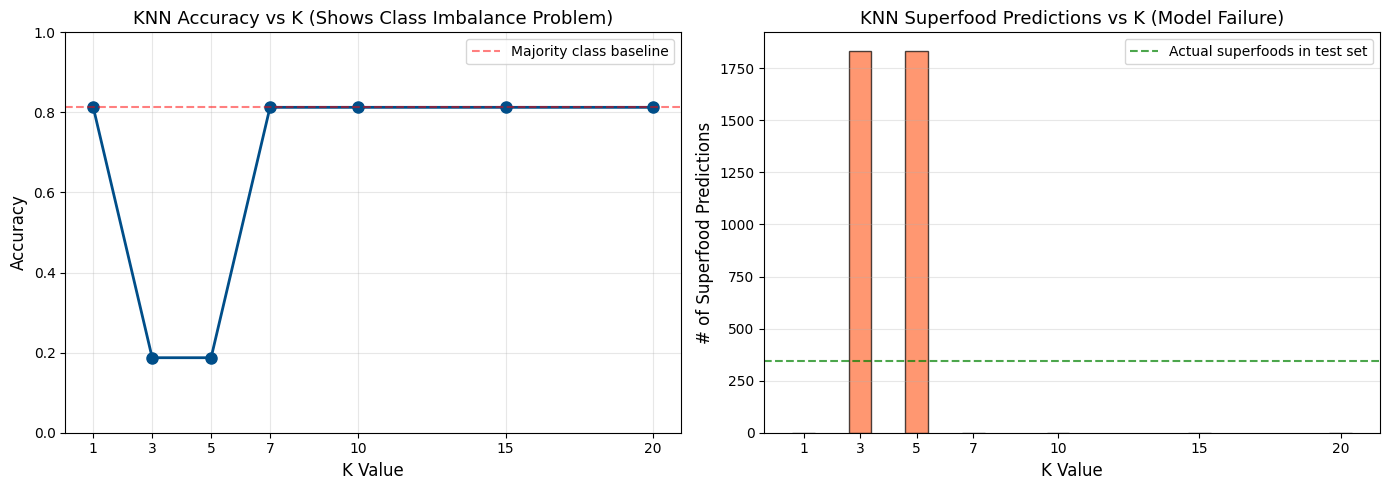

In [ ]:
# K-VALUE OPTIMIZATION

# Test different k values and track predictions
k_values = [1, 3, 5, 7, 10, 15, 20]
accuracies = []
superfood_predictions = []

for k in k_values:
    preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k)
    accuracy = (preds == y_test).mean()
    superfood_pred_count = np.sum(preds == 1)

    accuracies.append(accuracy)
    superfood_predictions.append(superfood_pred_count)
    print(f"k={k}: Accuracy = {accuracy:.4f}, Superfoods predicted = {superfood_pred_count}")

# Create subplot with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(k_values, accuracies, marker='o', linewidth=2, markersize=8, color='#004E89')
ax1.axhline(y=0.8127, color='red', linestyle='--', alpha=0.5, label='Majority class baseline')
ax1.set_xlabel('K Value', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('KNN Accuracy vs K (Shows Class Imbalance Problem)', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)
ax1.set_ylim([0, 1])
ax1.legend()

# Plot 2: Number of superfood predictions
ax2.bar(k_values, superfood_predictions, color='#FF6B35', alpha=0.7, edgecolor='black')
ax2.axhline(y=343, color='green', linestyle='--', alpha=0.7, label='Actual superfoods in test set')
ax2.set_xlabel('K Value', fontsize=12)
ax2.set_ylabel('# of Superfood Predictions', fontsize=12)
ax2.set_title('KNN Superfood Predictions vs K (Model Failure)', fontsize=13)
ax2.set_xticks(k_values)
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

The KNN failed on the imbalanced dataset, predicting zero superfoods regardless of k value. The 81.27% accuracy simply reflected the proportion of regular foods - the model was just guessing the majority class.

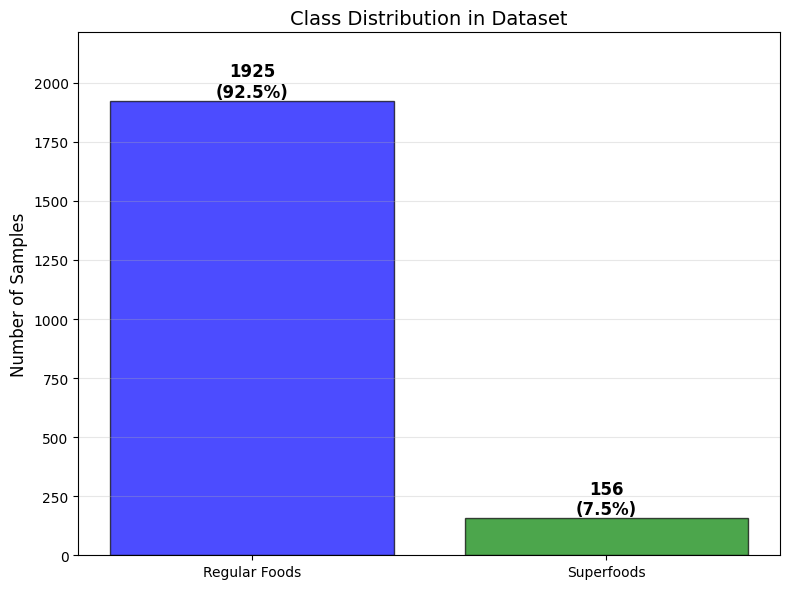

Total samples: 2081
Imbalance ratio: 12.34:1


In [ ]:
# Count classes
superfood_count = df_cleaned['superfood'].sum()  # True = 1
regular_count = len(df_cleaned) - superfood_count

# Create bar chart
plt.figure(figsize=(8, 6))
classes = ['Regular Foods', 'Superfoods']
counts = [regular_count, superfood_count]
colors = ['blue', 'green']

bars = plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(df_cleaned)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14)
plt.ylim([0, max(counts) * 1.15])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total samples: {len(df_cleaned)}")
print(f"Imbalance ratio: {regular_count/superfood_count:.2f}:1")

## Model Comparison

/tmp/ipython-input-1276328560.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



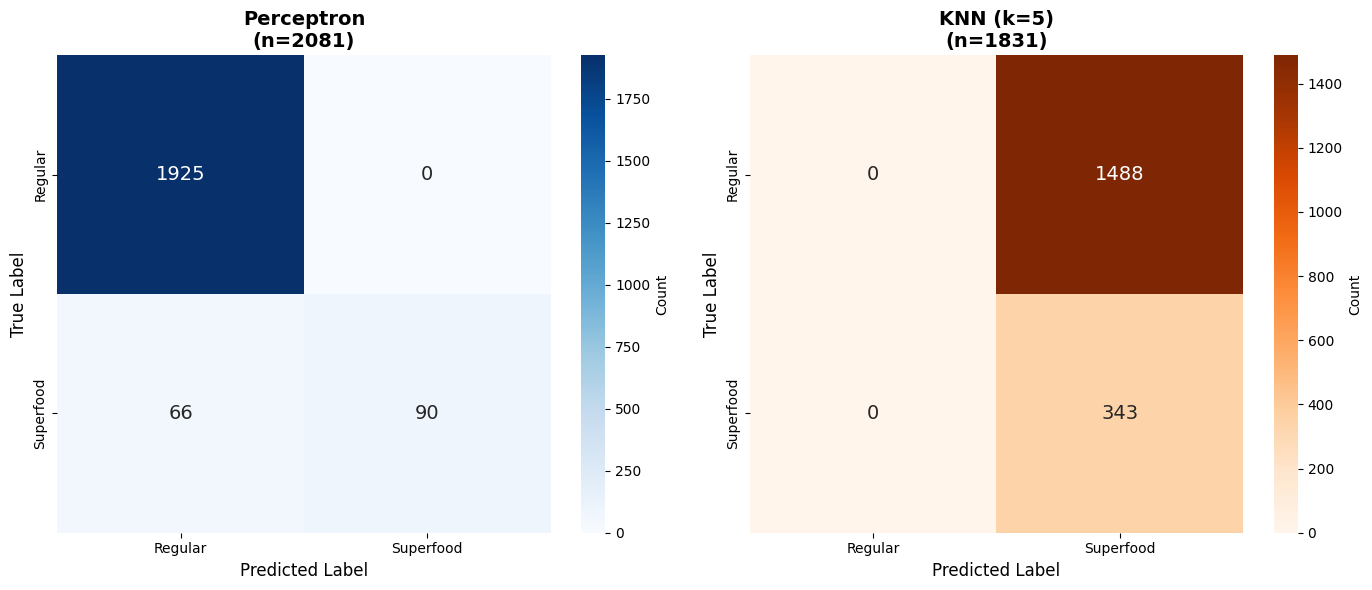


PERCEPTRON: 1925 0 66 90
KNN: 0 1488 0 343


In [ ]:
# CONFUSION MATRICES

# Feature columns used in Perceptron
feature_columns_perceptron = [
    'Total lipid (fat) (G)', 'Fatty acids, total saturated (G)',
    'Fatty acids, total trans (G)', 'Cholesterol (MG)',
    'Carbohydrate, by difference (G)', 'Fiber, total dietary (G)',
    'Total Sugars (G)', 'Protein (G)', 'Vitamin D (D2 + D3) (UG)',
    'Calcium, Ca (MG)', 'Iron, Fe (MG)', 'Potassium, K (MG)', 'Sodium, Na (MG)'
]

# Get the cleaned df with only these features (no NaN)
df_perceptron = df.dropna(subset=feature_columns_perceptron + ['superfood'])

# Standardize features
for feat in feature_columns_perceptron:
    df_perceptron[feat] = (df_perceptron[feat] - df_perceptron[feat].mean()) / df_perceptron[feat].std()

# Create X matrix with bias column
x_features = [df_perceptron[col].values for col in feature_columns_perceptron]
X_perceptron = np.vstack([np.ones(len(df_perceptron)), *x_features]).T

# Create y vector
y_perceptron = df_perceptron['superfood'].values

# Get predictions
perceptron_preds = np.where(X_perceptron @ fin_w >= 0, 1, -1)
perceptron_preds_binary = np.where(perceptron_preds == 1, 1, 0)

# KNN predictions
knn_preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k=5)

# Confusion matrices
cm_perceptron = confusion_matrix(y_perceptron, perceptron_preds_binary)
cm_knn = confusion_matrix(y_test, knn_preds)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Perceptron heatmap
sns.heatmap(cm_perceptron, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Regular', 'Superfood'],
            yticklabels=['Regular', 'Superfood'],
            cbar_kws={'label': 'Count'}, ax=axes[0], annot_kws={'size': 14})
axes[0].set_title(f'Perceptron\n(n={len(y_perceptron)})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# KNN heatmap
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Regular', 'Superfood'],
            yticklabels=['Regular', 'Superfood'],
            cbar_kws={'label': 'Count'}, ax=axes[1], annot_kws={'size': 14})
axes[1].set_title(f'KNN (k=5)\n(n={len(y_test)})', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nPERCEPTRON:", cm_perceptron[0,0], cm_perceptron[0,1], cm_perceptron[1,0], cm_perceptron[1,1])
print("KNN:", cm_knn[0,0], cm_knn[0,1], cm_knn[1,0], cm_knn[1,1])

PERFORMANCE METRICS COMPARISON
           Perceptron     KNN
Accuracy       0.9683  0.1873
Precision      1.0000  0.1873
Recall         0.5769  1.0000
F1-Score       0.7317  0.3155


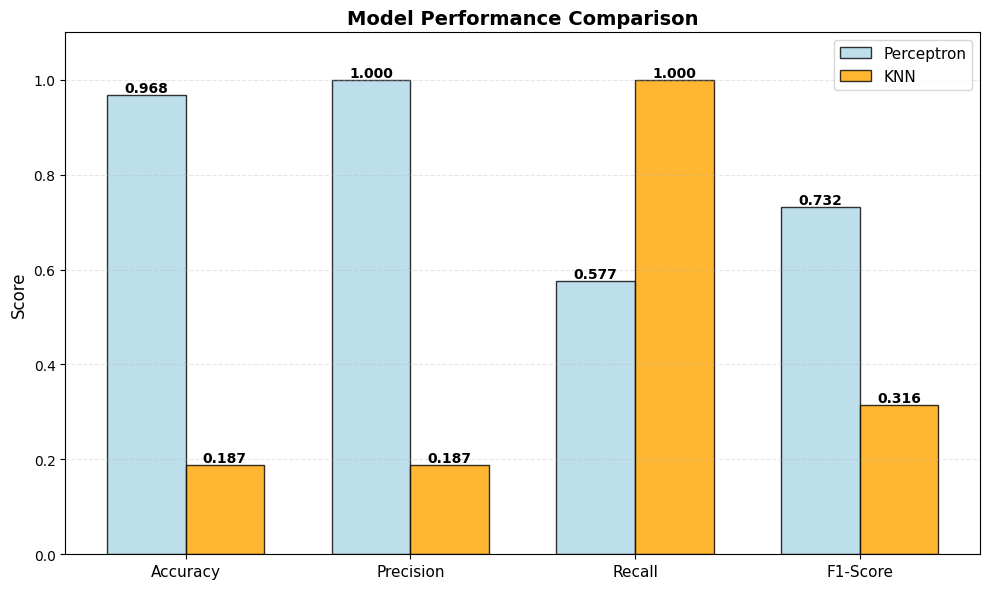

In [ ]:
# PERFORMANCE METRICS TABLE/BAR CHART

perceptron_preds_binary = np.where(X_perceptron @ fin_w >= 0, 1, 0)  # Corrected to use X_perceptron
y_perceptron_binary = np.array([1 if label == 1 else 0 for label in y_perceptron])  # Corrected to use y_perceptron

perceptron_accuracy = accuracy_score(y_perceptron_binary, perceptron_preds_binary)
perceptron_precision = precision_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)
perceptron_recall = recall_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)
perceptron_f1 = f1_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)

# KNN metrics
knn_preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k=5)

knn_accuracy = accuracy_score(y_test, knn_preds)
knn_precision = precision_score(y_test, knn_preds, zero_division=0)
knn_recall = recall_score(y_test, knn_preds, zero_division=0)
knn_f1 = f1_score(y_test, knn_preds, zero_division=0)

# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Perceptron': [perceptron_accuracy, perceptron_precision, perceptron_recall, perceptron_f1],
    'KNN': [knn_accuracy, knn_precision, knn_recall, knn_f1]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("PERFORMANCE METRICS COMPARISON")
print(metrics_df.round(4))

# bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_df.index))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_df['Perceptron'], width,
               label='Perceptron', color='lightblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, metrics_df['KNN'], width,
               label='KNN', color='orange', alpha=0.8, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, fontsize=11)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Initial Approach

The initial question we proposed for the Machine Learning part is "Can we predict whether a food item is classified as a 'superfood' based on its nutritional facts?", and after further discussions and analysis, we identified we can try building classification models based on a Perceptron for the set of 13 nutritional facts and KNN with k=5 as our baseline. We began by loading and merging two datasets, superfoods_df and foods_df, creating a new column with a  target variable, 1 for superfood, 0 for regular food, and cleaning the data to 2081 samples after dropping rows with missing values. However, as we moved forward with the KNN analysis, after a 70-30 train-test split, we got unexpectedly low accuracy values of 18.7% and observed that the model was predicting nearly everything as superfood, resulting in perfect Recall = 1.000 but extremely poor Precision = 0.187. This made us reconsider our initial attempt and go with the Perceptron using standardized features. After implementing the Perceptron, we got an Accuracy = 96.8%, a Precision = 1.000, and a Recall = 0.577, which showed significantly better results compared to KNN. From here, we decided to fix our model by incorporating different k values for KNN,testing k=3, k=7, k=9,to see if we could balance the extreme bias toward predicting superfoods. Building the KNN model with adjusted k values struggled to create an accurate model causing it to be significantly worse than the Perceptron model, with the Perceptron achieving an F1-Score = 0.732 compared to KNN's F1-Score = 0.316.

## Model 1: Perceptron Classifier

First, we analyzed Model 1: Perceptron Classifier using a subset of 13 standardized features, to filter out less important features and those with many NaN values. We then calculated: Accuracy = 96.8%, Precision = 1.000, Recall = 0.577, and F1-Score = 0.732, where the accuracy value is significantly higher than the KNN model and precision represents perfect performance with zero false positives. Based on the confusion matrix, we can see that the model correctly classified all 1925 regular foods but misclassified 66 out of 156 superfoods as regular foods. The perfect Precision = 1.000 indicates that when the Perceptron predicts a superfood, it is always correct, while the medium-level Recall = 0.577 shows that the model captures only 57.7% of the actual superfoods. Looking at the 3D scatter plot of Protein, Fiber, and Total Fat features, we can see that, although there is some seperation between superfoods and regular foods,the seperation is not to the degree that the model represents its ability to predict superfoods, meaning the Perceptron relies on all 13 features to establish its decision boundary. The convergence plots show accuracy rapidly increasing from 50% to 97% within 200 iterations, with misclassifications dropping from over 1000 to plateuing at 66 errors. Finally, we see that the model achieved near-perfect precision at the cost of recall. The With an F1-Score of 0.732, the Perceptron shows its a strong and accurate model, despite missing 42.3% of actual superfoods.

## Model 2:K-Nearest Neighbors (k=5)


Second, we analyzed Model 2: K-Nearest Neighbors Classifier with k=5 using a 70-30 train-test split. We calculated accuracy to be 18.7%, precision to be 0.187, recall to be 1.000, and the F1-Score to be 0.316. Based on the confusion matrix, we can see that the model predicted all 1831 test samples as superfoods, resulting in True Positives = 343 and False Positives = 1488, with zero predictions for regular foods. The perfect Recall = 1.000 represents that the model captured all actual superfoods, but the extremely low Precision = 0.187 shows that only 18.7% of its predictions were correct. Looking at the KNN Accuracy vs K plot, we can see dramatic chanfes in performance, with accuracy dropping from 81.27% at k=1 to 18.73% at k=3 and k=5, then returning to 81.27% for k≥7. The second plot shows that only k=3 and k=5 predicted superfoods, while all other k values predicted zero superfoods.This helps supporrt the idea that using a KNN model isn't a great fit for this dataset because the classes are severely imbalanced and the nutrient data doesn't provide sufficient discriminative power. Since most foods are labeled as regular foods, KNN ends up predicting that category almost every time for larger k values, while smaller k values become overwhelmed by local minority class samples. On top of that, many foods have similar or incomplete nutrient profiles, so the distance calculations that KNN relies on don't actually help separate the two groups. The result is a model that either ignores the minority class entirely (k≥7) or predicts everything as the minority class,k=3, k=5, and doesn't improve, even when tweaking the k parameter. Finally, we see that KNN performed significantly worse than the Perceptron with F1-Score = 0.316 compared to 0.732. Therefore, the KNN model shows poor overall performance.


## Conclusion:

These findings paint a complex picture of the superfood classification challenge. While the Perceptron provided our best results among the attempted approaches, the evident performance differences between models and the severe class imbalances reveal fundamental challenges in our modeling strategy or dataset.

First, the clear impact of class imbalance across both models suggests larger systemic issues in our classification protocol. The ratio of superfoods to regular foods vastly impacted both models' behavior in opposite ways. The Perceptron achieved perfect precision by being extremely conservative, predicting superfoods only when highly confident, while KNN switched between predicting either everything as a superfood or nothing as superfoods. The potential overlapping nutrient profiles between superfoods and normal foods caused both models to struggle with clear decision boundaries.

The Perceptron's Precision = 1.000, but Recall = 0.577 shows it avoids false guesses at the cost of missing 42.3% of actual superfoods. KNN's Recall = 1.000 but Precision = 0.187 captures all superfoods but incorrectly labels 81.3% of regular foods. This indicates that with the current 13 nutritional features, models are forced to be very polar in how aggressive their guessing is.

Finally, in terms of the F1-Score, the Perceptron achieves a reasonable balance despite limitations, while KNN demonstrates near-complete failure with a very low score of 0.316. This performance gap could be caused by overlapping feature distributions among foods or a potential fundamental difficulty in defining superfoods based only on a set 12 nutrtional facts.

Future research directions might include:
- Explore other nutritional facts as independent variables
- Attempt Logistic Regression or other linear classification models that may handle imbalanced data more effectively than Perceptron
- Applying cross-validation for more reliable evaluation
- Expand the dataset to be comprised of a larger variety of superfoods and regular foods

